# Representation Manipulation in BERT Sentiment Classification

## Overview
In this notebook, we aim to measure the effect of manipulating the representation of a BERT model on sentiment classification tasks. Specifically, we will subtract an average positive [CLS] vector from the output of the last layer and observe the impact on model performance and confidence. The main steps in this analysis include:

### 1. Dta Preparation
- We load the IMDB dataset using the `datasets` library.
- The text data is tokenized using the BERT tokenizer, retaining the original text for analysis.

### 2. Model Finetuning
- A pre-trained BERT model for sequence classification is loaded and fine-tuned on the IMDB dataset.

### 3. Representation Manipulation
- For each test instance, we manipulate its [CLS] vector by subtracting the average positive [CLS] vector.
- The manipulated [CLS] vector is passed through the classifier to obtain new predictions and confidence levels.

### 4. Analysis of Results
- **Confusion Matrices**: Visualize the confusion matrices for original and manipulated predictions.
- **Classification Reports**: Print and compare the classification reports.
- **Confidence Analysis**: Analyze and visualize the changes in confidence levels.
- **Example Cases**: Display specific examples of instances where the predictions changed, with options to filter by correctness of original predictions and confidence change thresholds.
- **Label Changes**: Categorize and visualize the label changes after manipulation.

By following these steps, we aim to understand the impact of manipulating internal representations on model performance and confidence, providing insights into the model's behavior and robustness.


# Experimental Workflow


## Setup Environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required Packages

In [3]:
%%capture
!pip install transformers datasets
!pip install accelerate -U
!pip install tqdm
!pip install datasets

### Import Libraries

In [98]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, load_from_disk
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn

## Data Prepration

In [74]:
# Load the dataset
dataset = load_dataset('imdb')

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the data
def preprocess(data):
    return tokenizer(data['text'], padding=True, truncation=True)

encoded_dataset = dataset.map(preprocess, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels', 'text'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

The following two cells, are to save and load the preprocessed data, as it takes long to preprocess it every time.

In [75]:
# Save the preprocessed dataset

encoded_dataset_dict = DatasetDict({
    'train': encoded_dataset['train'],
    'test': encoded_dataset['test']
})

encoded_dataset_dict.save_to_disk('./encoded_dataset_with_text')

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

In [6]:
%cd /content/drive/MyDrive/Interpretability/BERT-Classification

/content/drive/.shortcut-targets-by-id/1AeFF_BtjJq1nbHxHHolrr9cKtRty3JKk/Interpretability/BERT-Classification


In [88]:
# Load preprocessed dataset from disk
encoded_dataset = load_from_disk('./encoded_dataset_with_text')
# Extract test dataset
test_dataset = encoded_dataset['test']

## Model Fine-Tuning
Fine-tune the BERT model on the IMDB dataset to improve its performance on sentiment classification.


In [ ]:
# Fine-tune the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test']
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.227000,0.223126
2,0.126800,0.211011
3,0.054900,0.276669


TrainOutput(global_step=4689, training_loss=0.14920879635736617, metrics={'train_runtime': 9348.1084, 'train_samples_per_second': 8.023, 'train_steps_per_second': 0.502, 'total_flos': 1.9733329152e+16, 'train_loss': 0.14920879635736617, 'epoch': 3.0})

The following cell is to load th saved model.

In [8]:
# Load the fine-tuned model from the checkpoint
checkpoint_dir = './results/checkpoint-4500'
model = BertForSequenceClassification.from_pretrained(checkpoint_dir)

### Make Predictions

In [ ]:
# Use the fine-tuned model to make predictions on the test dataset
predictions = trainer.predict(test_dataset)
logits = predictions.predictions

# Apply softmax to get probabilities
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

# Get predicted labels by finding the max probability
predicted_labels = torch.argmax(probs, dim=1)

The following two cells are to save and load the predicted labels.

In [ ]:
# Convert the predicted labels tensor to a NumPy array
predicted_labels_np = predicted_labels.numpy()

# Save the predicted labels to a file
np.save('./predicted_labels.npy', predicted_labels_np)

In [9]:
# Load the predicted labels from the file
predicted_labels_np = np.load('./predicted_labels.npy')

# Convert the NumPy array back to a PyTorch tensor
predicted_labels = torch.tensor(predicted_labels_np)

## Representation Manipulation



### Extract Positive [CLS] Vectors and Calculate Average Positive Vector

In [11]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Move the model to the correct device
model.to(device)
model.eval()
model.config.output_hidden_states = True

# Filter out positive instances and calculate the average [CLS] vector
positive_indices = torch.where(predicted_labels == 1)[0]

positive_cls_vectors = []
predictions_logits = []

# Iterate through positive instances to collect [CLS] vectors
for index in tqdm(positive_indices):
    torch.cuda.empty_cache()
    index = index.item()
    input_ids = encoded_dataset['test'][index]['input_ids'].unsqueeze(0).to(device)
    attention_mask = encoded_dataset['test'][index]['attention_mask'].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        cls_vector = outputs.hidden_states[-1][:, 0, :].squeeze().cpu()  # Move to CPU
        positive_cls_vectors.append(cls_vector)

# Calculate the average positive [CLS] vector
positive_cls_vectors = torch.stack(positive_cls_vectors)
avg_positive_vector = positive_cls_vectors.mean(dim=0)

100%|██████████| 12872/12872 [07:34<00:00, 28.35it/s]


The following two cells are to save and load the result above.

In [13]:
# Save the average positive [CLS] vector and predictions logits
torch.save(avg_positive_vector, 'avg_positive_vector.pt')

In [14]:
# Load the average positive [CLS] vector and predictions logits
avg_positive_vector = torch.load('avg_positive_vector.pt')

### Implementing Manipulation

In [18]:
def manipulate_representation(input_ids, attention_mask, avg_vector, model):
    with torch.no_grad():

        # Forward pass through the model to get hidden states
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # Extract the [CLS] token representation
        cls_vector = outputs.hidden_states[-1][:, 0, :]

        # Subtract the average positive vector from the [CLS] token representation
        manipulated_cls_vector = cls_vector - avg_vector.unsqueeze(0)

        # Pass the manipulated vector through the classifier to get new logits
        logits = model.classifier(manipulated_cls_vector)

        # Calculate probabilities using softmax and get predicted labels
        probs = torch.nn.functional.softmax(logits, dim=-1)
        confidence, predicted_label = torch.max(probs, dim=1)

    # Return the predicted label and confidence
    return predicted_label.item(), confidence.item(), probs


### Analysis of Results

In [19]:
# Store results for reporting
total_instances = len(encoded_dataset['test'])
true_labels = [encoded_dataset['test'][i]['labels'] for i in range(total_instances)]
original_predictions = []
original_confidences = []
manipulated_predictions = []
manipulated_confidences = []
original_probs = []
manipulated_probs = []

# Loop over each instance in the test set
for i in tqdm(range(total_instances), desc="Evaluating manipulated representations"):
    input_ids = encoded_dataset['test'][i]['input_ids'].unsqueeze(0).to(device)
    attention_mask = encoded_dataset['test'][i]['attention_mask'].unsqueeze(0).to(device)

    # Original prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        original_prob = torch.nn.functional.softmax(outputs.logits, dim=-1)
        original_confidence, original_predicted_label = torch.max(original_prob, dim=1)

    # Manipulated prediction
    manipulated_label, manipulated_confidence,  manipulated_prob = manipulate_representation(
        input_ids, attention_mask, avg_positive_vector.to(device), model
    )

    # Store the results
    original_predictions.append(original_predicted_label.item())
    original_confidences.append(original_confidence.item())
    manipulated_predictions.append(manipulated_label)
    manipulated_confidences.append(manipulated_confidence)
    original_probs.append(original_prob.cpu().numpy())  # Convert to numpy array for saving
    manipulated_probs.append(manipulated_prob.cpu().numpy())  # Convert to numpy array for saving

Evaluating manipulated representations: 100%|██████████| 25000/25000 [28:13<00:00, 14.77it/s]


The following cell is to save the results to retrieve later.

In [20]:
# Save results to disk
np.save('true_labels.npy', np.array(true_labels))
np.save('original_predictions.npy', np.array(original_predictions))
np.save('original_confidences.npy', np.array(original_confidences))
np.save('manipulated_predictions.npy', np.array(manipulated_predictions))
np.save('manipulated_confidences.npy', np.array(manipulated_confidences))
np.save('original_probs.npy', np.array(original_probs, dtype=object))  # Save as object to handle arrays
np.save('manipulated_probs.npy', np.array(manipulated_probs, dtype=object))  # Save as object to handle arrays

In [22]:
# Load arrays from disk
true_labels_np = np.load('true_labels.npy')
original_predictions_np = np.load('original_predictions.npy')
original_confidences_np = np.load('original_confidences.npy')
manipulated_predictions_np = np.load('manipulated_predictions.npy')
manipulated_confidences_np = np.load('manipulated_confidences.npy')
original_probs_np = np.load('original_probs.npy', allow_pickle=True)
manipulated_probs_np = np.load('manipulated_probs.npy', allow_pickle=True)

# Convert numpy arrays back to lists if needed
true_labels = true_labels_np.tolist()
original_predictions = original_predictions_np.tolist()
original_confidences = original_confidences_np.tolist()
manipulated_predictions = manipulated_predictions_np.tolist()
manipulated_confidences = manipulated_confidences_np.tolist()
original_probs = original_probs_np.tolist()
manipulated_probs = manipulated_probs_np.tolist()

In [101]:
class RepresentationAnalysis:
    def __init__(self, true_labels, original_predictions, original_confidences, manipulated_predictions, manipulated_confidences, original_probs, manipulated_probs):
        self.true_labels = np.array(true_labels)
        self.original_predictions = np.array(original_predictions)
        self.original_confidences = np.array(original_confidences)
        self.manipulated_predictions = np.array(manipulated_predictions)
        self.manipulated_confidences = np.array(manipulated_confidences)
        self.original_probs = np.array(original_probs)
        self.manipulated_probs = np.array(manipulated_probs)

        # Create a dataframe to store results
        self.df = pd.DataFrame({
            'true_label': self.true_labels,
            'original_prediction': self.original_predictions,
            'manipulated_prediction': self.manipulated_predictions,
            'original_confidence': self.original_confidences,
            'manipulated_confidence': self.manipulated_confidences
        })
        self.df['prediction_changed'] = self.df['original_prediction'] != self.df['manipulated_prediction']
        self.df['confidence_change'] = self.df['original_confidence'] - self.df['manipulated_confidence']

    def plot_confusion_matrix(self):
        # Confusion matrix for original predictions
        cm_original = confusion_matrix(self.true_labels, self.original_predictions, labels=[0, 1])
        disp_original = ConfusionMatrixDisplay(confusion_matrix=cm_original, display_labels=['Negative', 'Positive'])
        disp_original.plot()
        plt.title('Confusion Matrix - Original Predictions')
        plt.show()

        # Confusion matrix for manipulated predictions
        cm_manipulated = confusion_matrix(self.true_labels, self.manipulated_predictions, labels=[0, 1])
        disp_manipulated = ConfusionMatrixDisplay(confusion_matrix=cm_manipulated, display_labels=['Negative', 'Positive'])
        disp_manipulated.plot()
        plt.title('Confusion Matrix - Manipulated Predictions')
        plt.show()


    def classification_report(self):
        # Classification report for original predictions
        report_original = classification_report(self.true_labels, self.original_predictions, target_names=['Negative', 'Positive'])
        print("Classification Report - Original Predictions:")
        print(report_original)

        # Classification report for manipulated predictions
        report_manipulated = classification_report(self.true_labels, self.manipulated_predictions, target_names=['Negative', 'Positive'])
        print("Classification Report - Manipulated Predictions:")
        print(report_manipulated)

    def confidence_analysis(self):
        # Analyze confidence changes

        overall_confidence_change = self.df['confidence_change'].mean()
        print(f"Overall Mean Confidence Change: {overall_confidence_change:.4f}")

        confidence_changes_same = self.df[self.df['prediction_changed'] == False]['confidence_change']
        confidence_changes_different = self.df[self.df['prediction_changed'] == True]['confidence_change']


        print("\nMean confidence change when prediction stays the same:")
        print(confidence_changes_same.describe())

        print("\nMean confidence change when prediction changes:")
        print(confidence_changes_different.describe())

        changes = {
            'Positive to Positive': self.df[(self.df['original_prediction'] == 1) & (self.df['manipulated_prediction'] == 1)],
            'Positive to Negative': self.df[(self.df['original_prediction'] == 1) & (self.df['manipulated_prediction'] == 0)],
            'Negative to Positive': self.df[(self.df['original_prediction'] == 0) & (self.df['manipulated_prediction'] == 1)],
            'Negative to Negative': self.df[(self.df['original_prediction'] == 0) & (self.df['manipulated_prediction'] == 0)],
        }

        for change_type, subset in changes.items():
            print(f"\n{change_type}:")
            print(f"Count: {len(subset)}")
            # print(subset['confidence_change'].describe())
            print(f"Mean Confidence Change: {subset['confidence_change'].mean()}")


        # Plot histograms for confidence changes
        plt.hist(confidence_changes_same, bins=30, alpha=0.75, label='Prediction Stays Same')
        plt.hist(confidence_changes_different, bins=30, alpha=0.75, label='Prediction Changes')
        plt.title('Histogram of Confidence Changes')
        plt.xlabel('Change in Confidence')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    def show_examples(self, from_label, to_label, num_examples=5, only_correct_original=False, only_incorrect_original=False, min_confidence_change=None, max_confidence_change=None):
        # Filter the dataframe for the specified transition
        examples = self.df[(self.df['original_prediction'] == from_label) & (self.df['manipulated_prediction'] == to_label)]

        if only_correct_original and only_incorrect_original:
          raise ValueError("Cannot set both only_correct_original and only_incorrect_original to True.")

        if only_correct_original:
          # Further filter to include only correct original predictions
          examples = examples[examples['true_label'] == examples['original_prediction']]

        if only_incorrect_original:
          # Further filter to include only incorrect original predictions
          examples = examples[examples['true_label'] != examples['original_prediction']]

        if min_confidence_change is not None:
          # Further filter to include only examples with confidence change above min_confidence_change
          examples = examples[examples['confidence_change'] >= min_confidence_change]

        if max_confidence_change is not None:
          # Further filter to include only examples with confidence change below max_confidence_change
          examples = examples[examples['confidence_change'] <= max_confidence_change]

        # Display the specified number of examples
        for idx in examples.head(num_examples).index:
            row = examples.loc[idx]
            text = encoded_dataset['test'][idx]['text']  # Assuming 'text' contains the comment text
            print(f"Example {idx}:")
            print(f"  Text: {text}")
            print(f"  True Label: {row['true_label']}")
            print(f"  Original Prediction: {row['original_prediction']} with Confidence: {row['original_confidence']}")
            print(f"  Manipulated Prediction: {row['manipulated_prediction']} with Confidence: {row['manipulated_confidence']}")
            print(f"  Change in Confidence: {row['confidence_change']}")
            print("-" * 40)

    def detailed_label_changes(self):
        # Categorize instances
        positive_to_positive = np.sum((self.original_predictions == 1) & (self.manipulated_predictions == 1))
        positive_to_negative = np.sum((self.original_predictions == 1) & (self.manipulated_predictions == 0))
        negative_to_positive = np.sum((self.original_predictions == 0) & (self.manipulated_predictions == 1))
        negative_to_negative = np.sum((self.original_predictions == 0) & (self.manipulated_predictions == 0))

        # Print results
        total_instances = len(self.true_labels)
        print(f"Positive to Positive: {positive_to_positive} ({positive_to_positive / total_instances * 100:.2f}%)")
        print(f"Positive to Negative: {positive_to_negative} ({positive_to_negative / total_instances * 100:.2f}%)")
        print(f"Negative to Positive: {negative_to_positive} ({negative_to_positive / total_instances * 100:.2f}%)")
        print(f"Negative to Negative: {negative_to_negative} ({negative_to_negative / total_instances * 100:.2f}%)")

        # Bar chart for label changes
        categories = ['+ to +', '+ to -', '- to +', '- to -']
        values = [positive_to_positive, positive_to_negative, negative_to_positive, negative_to_negative]

        plt.bar(categories, values)
        plt.title('Label Changes After Manipulation')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.show()


# Initialize the analysis class
analysis = RepresentationAnalysis(
    true_labels,
    original_predictions,
    original_confidences,
    manipulated_predictions,
    manipulated_confidences,
    original_probs,
    manipulated_probs
)

### Confusion Matrix Comparison

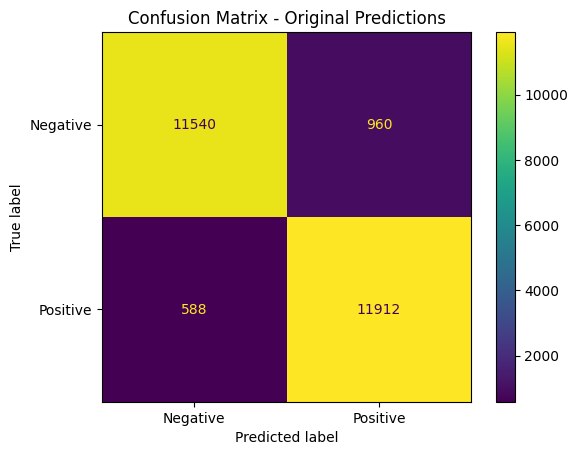

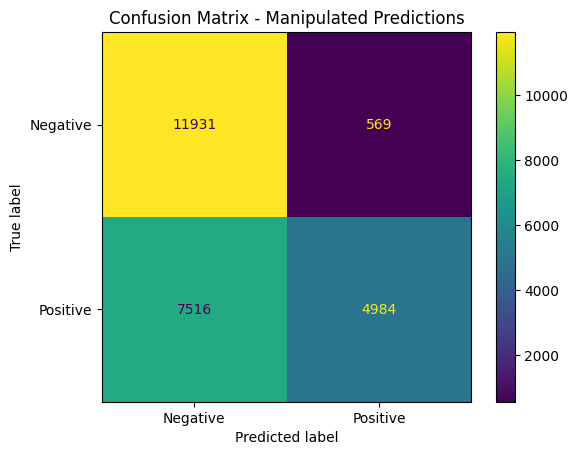

In [42]:
analysis.plot_confusion_matrix()         # Plot confusion matrices

### Classification Report Comparison

In [82]:
analysis.classification_report()         # Print classification reports

Classification Report - Original Predictions:
              precision    recall  f1-score   support

    Negative       0.95      0.92      0.94     12500
    Positive       0.93      0.95      0.94     12500

    accuracy                           0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000

Classification Report - Manipulated Predictions:
              precision    recall  f1-score   support

    Negative       0.61      0.95      0.75     12500
    Positive       0.90      0.40      0.55     12500

    accuracy                           0.68     25000
   macro avg       0.76      0.68      0.65     25000
weighted avg       0.76      0.68      0.65     25000



### Confidence Comparison

Overall Mean Confidence Change: 0.3496

Mean confidence change when prediction stays the same:
count    17681.000000
mean         0.303286
std          0.112390
min         -0.120235
25%          0.217153
50%          0.249920
75%          0.436828
max          0.499034
Name: confidence_change, dtype: float64

Mean confidence change when prediction changes:
count    7319.000000
mean        0.461610
std         0.063861
min        -0.138030
25%         0.461652
50%         0.472879
75%         0.484232
max         0.499033
Name: confidence_change, dtype: float64

Positive to Positive:
Count: 5553
Mean Confidence Change: 0.4608374739066773

Positive to Negative:
Count: 7319
Mean Confidence Change: 0.46160980040689265

Negative to Positive:
Count: 0
Mean Confidence Change: nan

Negative to Negative:
Count: 12128
Mean Confidence Change: 0.23114909210038373


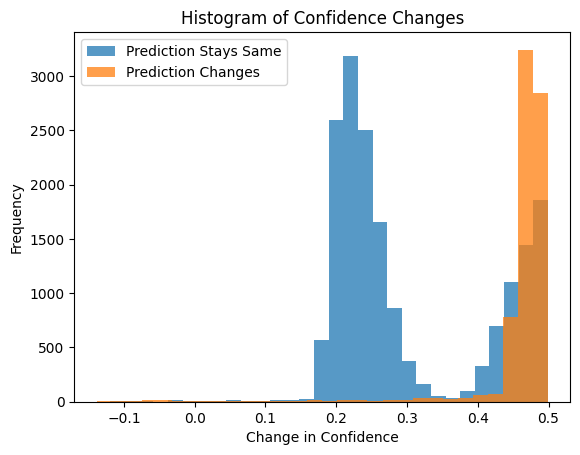

In [53]:
analysis.confidence_analysis()           # Analyze confidence changes

### Predicted Label Comparison

Positive to Positive: 5553 (22.21%)
Positive to Negative: 7319 (29.28%)
Negative to Positive: 0 (0.00%)
Negative to Negative: 12128 (48.51%)


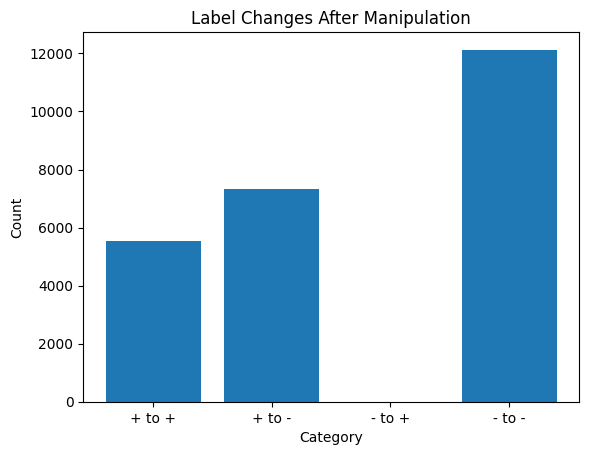

In [38]:
analysis.detailed_label_changes()        # Categorize and count label changes

### Show Examples

In [99]:
# Display examples where predictions changed from positive to negative and the original predictions were correct with a confidence change between 0.1 and 0.5
print("Correct Original Predictions with Confidence Change between 0.1 and 0.5:")
analysis.show_examples(
    from_label=1,
    to_label=0,
    num_examples=5,
    only_correct_original=True,
    min_confidence_change=0.1,
    max_confidence_change=0.5
)

Correct Original Predictions with Confidence Change between 0.1 and 0.5:
Example 12500:
  Text: Previous reviewer Claudio Carvalho gave a much better recap of the film's plot details than I could. What I recall mostly is that it was just so beautiful, in every sense - emotionally, visually, editorially - just gorgeous.<br /><br />If you like movies that are wonderful to look at, and also have emotional content to which that beauty is relevant, I think you will be glad to have seen this extraordinary and unusual work of art.<br /><br />On a scale of 1 to 10, I'd give it about an 8.75. The only reason I shy away from 9 is that it is a mood piece. If you are in the mood for a really artistic, very romantic film, then it's a 10. I definitely think it's a must-see, but none of us can be in that mood all the time, so, overall, 8.75.
  True Label: 1
  Original Prediction: 1 with Confidence: 0.9990772008895874
  Manipulated Prediction: 0 with Confidence: 0.5124976634979248
  Change in Confiden

In [100]:
# Display examples where predictions changed from positive to negative and the original predictions were incorrect with a confidence change greater than 0.2
print("\nIncorrect Original Predictions with Confidence Change greater than 0.2:")
analysis.show_examples(
    from_label=1,
    to_label=0,
    num_examples=5,
    only_incorrect_original=True,
    min_confidence_change=0.2
)


Incorrect Original Predictions with Confidence Change greater than 0.2:
Example 4:
  Text: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!
  True Label: 0
  Original Prediction: 1 with Confidence: 0.9989150762557983
  Manipulated Prediction: 0 with Confidence: 0.5070691108703613
  Change in Confidence: 0.491845965385437
----------------------------------------
Example 18:

# Discussion and Conclusions
In this analysis, we explored the impact of manipulating the representation of a BERT model on sentiment classification tasks. By subtracting an average positive [CLS] vector from the last layer's output, we observed changes in both predictions and confidence levels.

### Key Findings
- The manipulation led to a reduction in confidence for many instances (35% on average), even if the predictions did not change.
- There were notable changes in predictions from positive to negative (7319 instances), highlighting the influence of the average positive vector on model behavior.

### Future Work
- Explore different manipulation techniques, such as adding negative vectors or using different layers for manipulation.
- Investigate the impact of manipulation on other tasks and datasets to generalize the findings.

